# Sequence to sequence models

Sequence to sequence models are typically used for tasks like translation, summarization, question answering,...

## Install dependencies

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [2]:
%pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu124
%pip install tokenizers==0.20.3 transformers==4.46.3 pandas==2.2.3 datasets==3.1.0 sentencepiece==0.2.0 sacremoses==0.1.1

Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully un

## Load in a trained Albanian - English model

### Using a pipeline

In [3]:
from transformers import pipeline

pipe = pipeline("translation", model="Helsinki-NLP/opus-mt-sq-en", device="cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/300M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/822k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/300M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/805k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [4]:
pipe("Më pëlqen të lexoj libra")

[{'translation_text': 'I like reading books.'}]

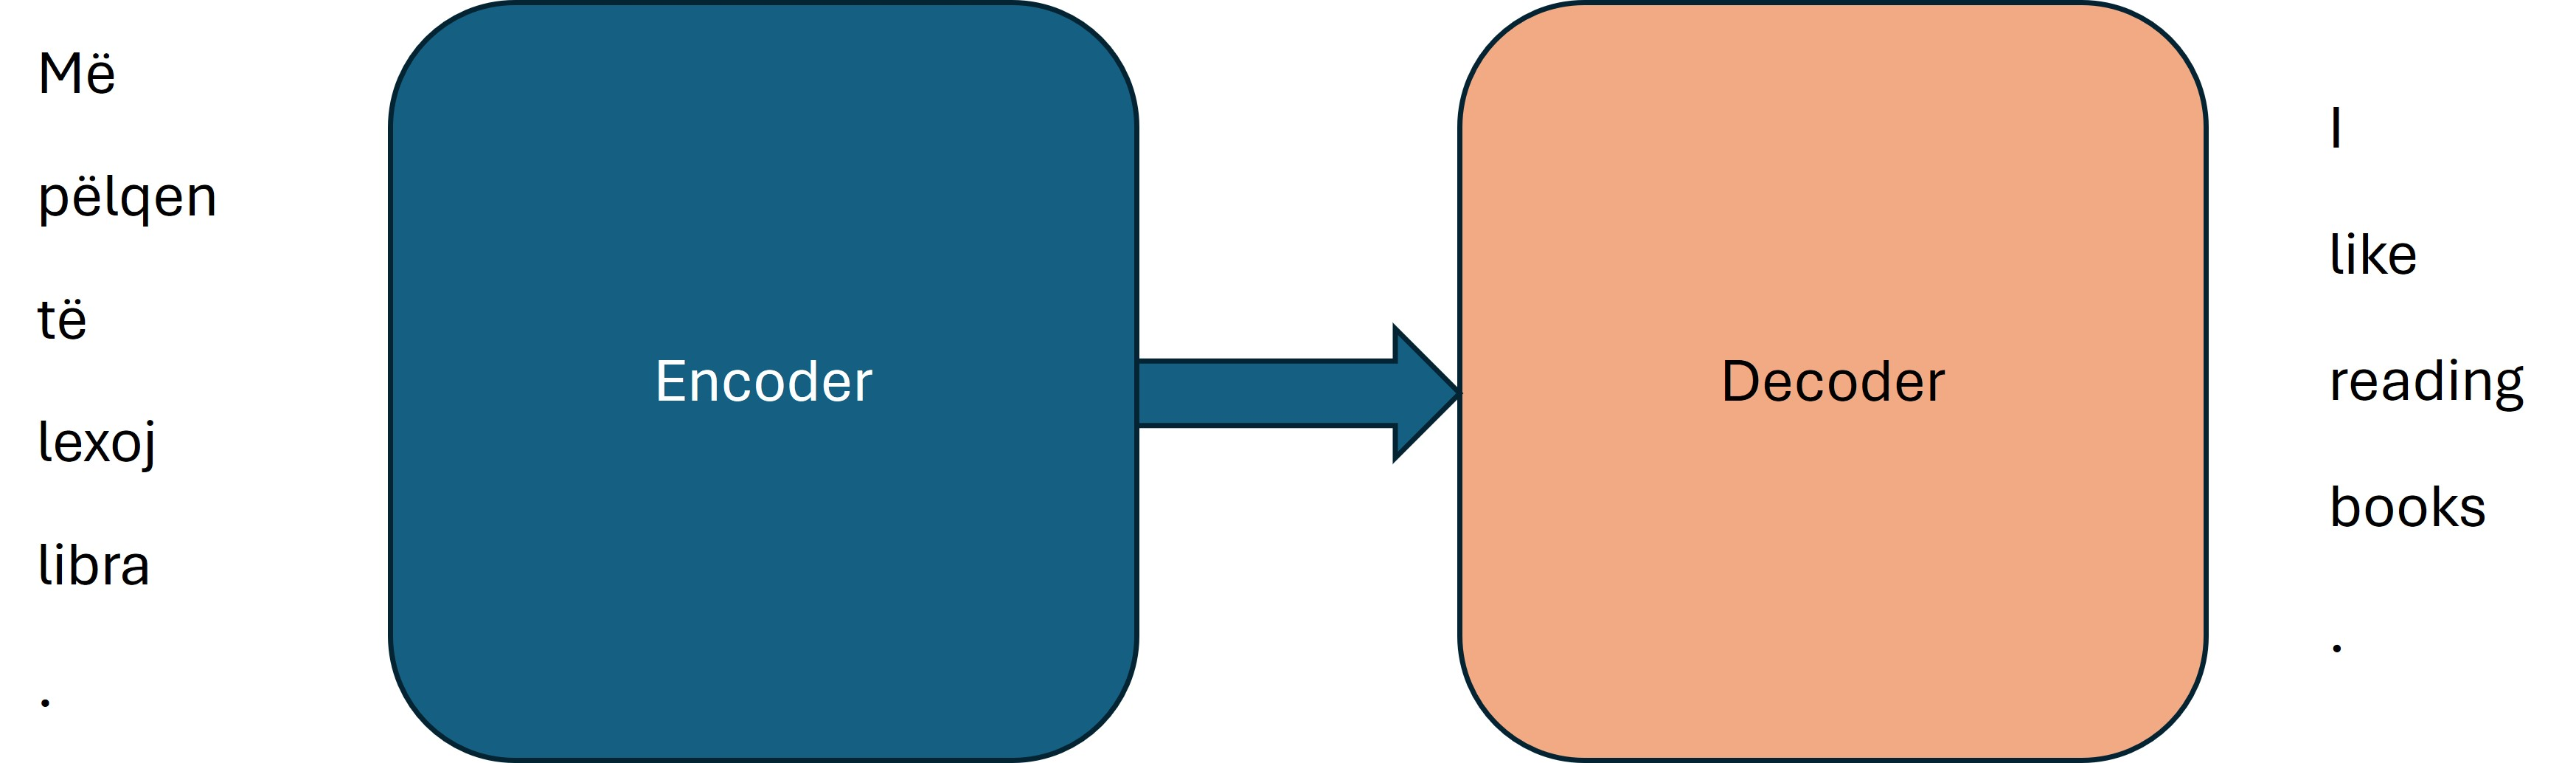

### More in detail loading in the model and tokenizer separately

In [7]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-sq-en")
model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-sq-en").to("cuda")

In [22]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-sq-en")

# Input sentence in Albanian
input_sentence = "Më pëlqen të lexoj libra."

# Tokenize the sentence to see the tokens
tokens = tokenizer.tokenize(input_sentence)
model_input = tokenizer.encode(input_sentence, return_tensors="pt").to("cuda")

print("Tokens:", tokens)
print("Input ids:", model_input)

Tokens: ['▁Më', '▁pëlqen', '▁të', '▁lexoj', '▁libra', '.']
Input ids: tensor([[ 175, 1162,    4, 9248, 7203,    2,    0]], device='cuda:0')


In [33]:
# Generate output token IDs
output_token_ids = model.generate(model_input)

# Decode the output token IDs into individual tokens
output_tokens = tokenizer.convert_ids_to_tokens(output_token_ids[0], skip_special_tokens=True)

# Decode the output token IDs into the translated sentence
output_sentence = tokenizer.decode(output_token_ids[0], skip_special_tokens=True)

print("Generated output IDs:", output_token_ids[0].tolist())
print("Generated tokens:", output_tokens)

Generated output IDs: [59157, 20, 163, 2311, 3209, 2, 0]
Generated tokens: ['▁I', '▁like', '▁reading', '▁books', '.']


In [34]:
tokenizer.decode(59157)

'<pad>'

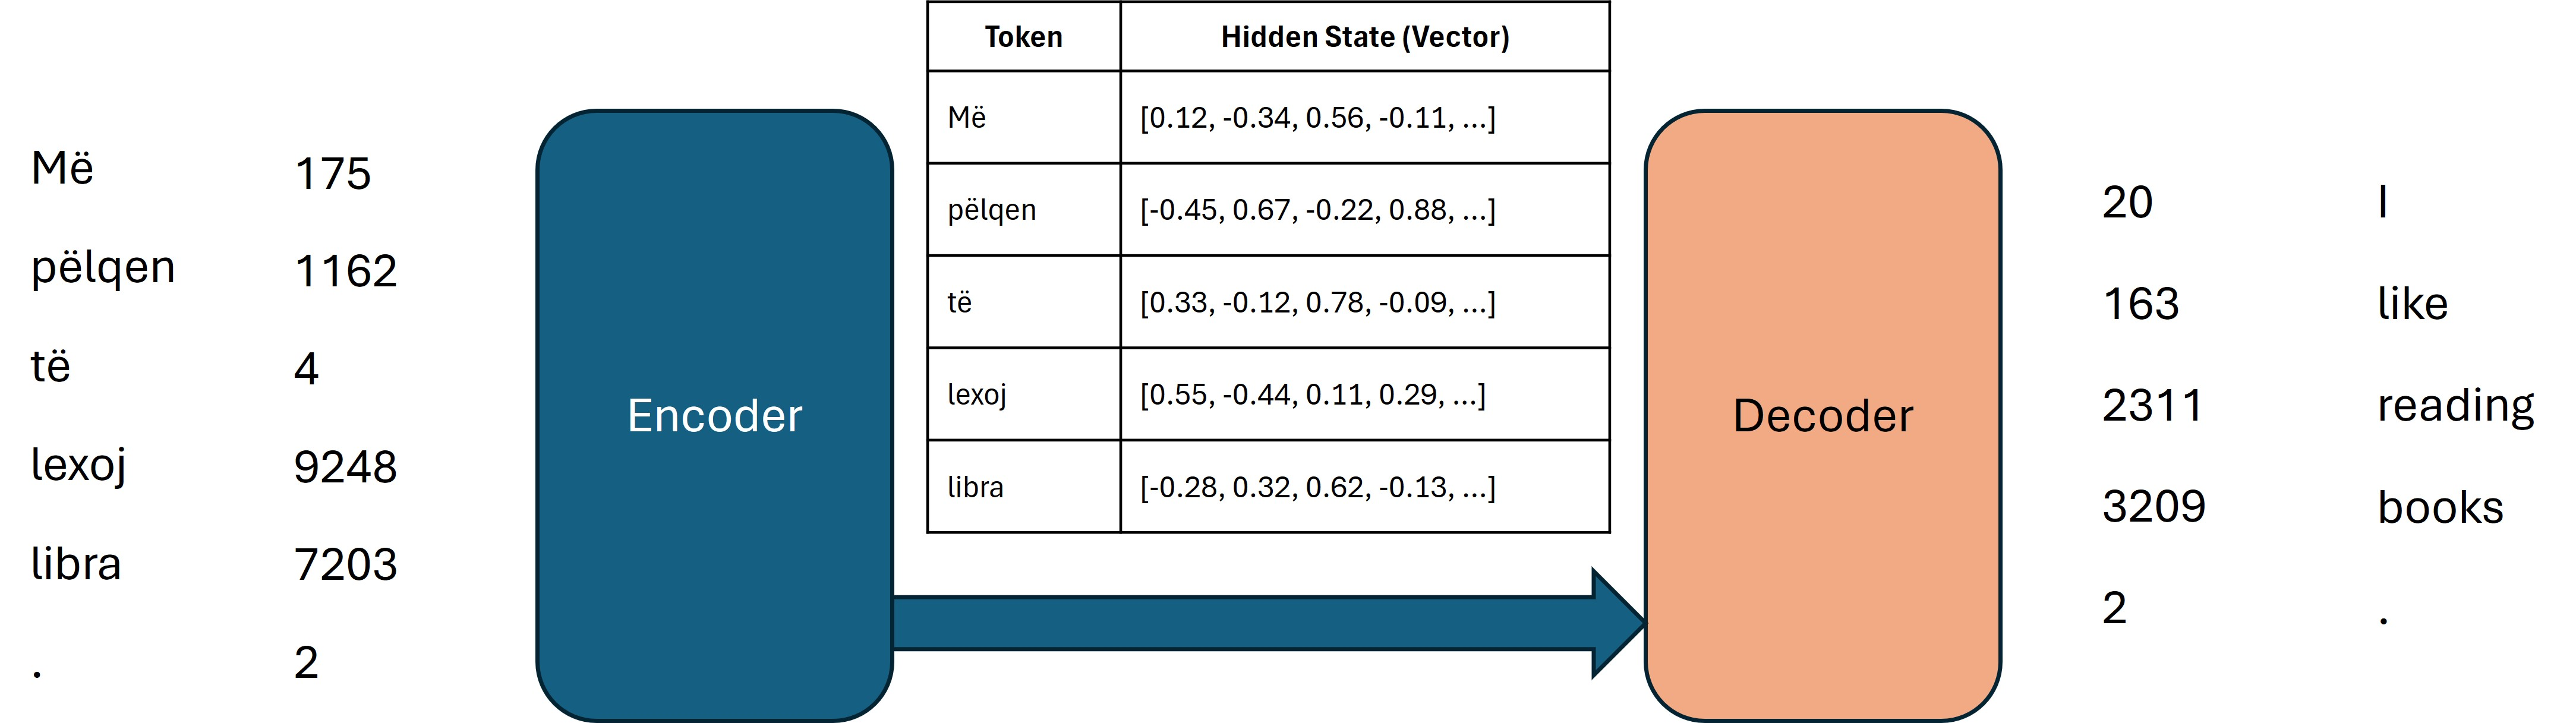

## Training a translation model

The model is already trained on a large dataset, but we will train it on more data.

All that is needed are sentence pairs of albanian sentences and their english translation.

We will load in a dataset of sentence pairs with Albanian sentences under column "sq" and their English translation under column "en".

### Load in the dataset

In [35]:
from datasets import load_dataset

ds = load_dataset("tools4eu/albanian-english-bundled")

README.md:   0%|          | 0.00/2.21k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/124M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3192496 [00:00<?, ? examples/s]

In [36]:
ds

DatasetDict({
    train: Dataset({
        features: ['sq', 'en', 'dataset', 'subset'],
        num_rows: 3192496
    })
})

In [38]:
ds["train"][0]

{'sq': 'Shonda Rhimes, titani që qëndron pas "Anatomia e Greit" (Grey\'s Anatomy), "Skandali" (Scandal) dhe "Si t\'i lejosh vetes çdo gjë" (How to Get Away With  Murder), është përgjegjëse për rreth 70 orë televizive në sezon, dhe ajo e dashuron punën. "Kur puna rëndohet, kur jam e zhytur në punë, asnjë ndjesi tjetër nuk ekziston", thotë ajo. Ajo ka një emër për këtë ndjesi: Gumëzhima. Gumëzhima është drogë, gumëzhima është muzikë, gumëzhima është pëshpëritja e Zotit në veshin e saj. Por çfarë ndodh kur ajo pushon? A ka ndonjë gjë tjetër përveç gumëzhimës? Në këtë ligjëratë prekëse, ndiqni Rhimes në rrugëtimin përgjatë "vitit të saj të \'po\'-së" dhe mësoni se si e rigjeti ajo gumëzhimën e saj.',
 'en': 'Shonda Rhimes, the titan behind Grey\'s Anatomy, Scandal and How to Get Away With Murder, is responsible for some 70 hours of television per season, and she loves to work. "When I am hard at work, when I am deep in it, there is no other feeling," she says. She has a name for this feeli

### Split the dataset into a train and test set

When training a model you need to make sure it does not overfit to your examples.

Overfitting means the model only performs well on your specific examples and loses the ability to generalize to new input it has not seen yet.

By taking out a part of your dataset, it can be used while training to make sure the model performs well on both data it is being trained on as well as data it has not trained on.

In [40]:
ds = ds["train"].train_test_split(test_size=0.1)

In [41]:
ds

DatasetDict({
    train: Dataset({
        features: ['sq', 'en', 'dataset', 'subset'],
        num_rows: 2873246
    })
    test: Dataset({
        features: ['sq', 'en', 'dataset', 'subset'],
        num_rows: 319250
    })
})

In [42]:
### Tokenize the dataset


### Tokenize the dataset

Same as before, we have to tokenize the dataset. The only difference this time is that we pass some extra parameters to avoid errors for input that is too long for the model. Each model has a maximum input length. For Helsinki models that maximum input length is 512 tokens.

In [47]:
from datasets import Dataset

class Seq2SeqDataset(Dataset):
    def __init__(self, dataset, tokenizer, source_lang='sq', target_lang='en'):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.source_lang = source_lang
        self.target_lang = target_lang

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        source_text = example[self.source_lang]
        target_text = example[self.target_lang]
        model_inputs = self.tokenizer(source_text, text_target=target_text, max_length=self.tokenizer.model_max_length, padding='max_length', truncation=True)
        return model_inputs


In [48]:
train_dataset = Seq2SeqDataset(ds['train'], tokenizer)
test_dataset = Seq2SeqDataset(ds['test'], tokenizer)

In [49]:
train_dataset[0]

{'input_ids': [426, 497, 127, 352, 324, 4, 4006, 908, 101, 8, 0, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 59157, 5915